In [1]:
#Add repo path to the system path
from pathlib import Path
import os, sys
repo_path= Path.cwd().resolve()
while '.gitignore' not in os.listdir(repo_path): # while not in the root of the repo
    repo_path = repo_path.parent #go up one level
sys.path.insert(0,str(repo_path)) if str(repo_path) not in sys.path else None

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="0"

from diffusers import StableDiffusionPipeline, DPMSolverMultistepScheduler
import torch
import numpy as np
from matplotlib import pyplot as plt
import cv2 as cv

# define model and load weights
output_dir='Likalto4/mammo40k_healthy-only'
pipe = StableDiffusionPipeline.from_pretrained(output_dir, safety_checker=None, torch_dtype=torch.float16).to("cuda")
generator = torch.Generator(device='cuda')
pipe.scheduler = DPMSolverMultistepScheduler.from_config(pipe.scheduler.config)
pipe.enable_xformers_memory_efficient_attention()

checkpoint-10000/unet/diffusion_pytorch_model.safetensors not found


Fetching 137 files:   0%|          | 0/137 [00:00<?, ?it/s]

In [2]:
def show_row(imgs, figsize=(10, 10), title="", **kwargs):
    """Show generated images in a row

    Args:
        imgs (list): images list (PILs or numpy arrays)
        figsize (tuple, optional): figure size. Defaults to (10, 10).
        title (str, optional): title. Defaults to "".
    """
    fig, axs = plt.subplots(1, len(imgs), figsize=figsize)
    fig.suptitle(title)
    for i, img in enumerate(imgs):
        axs[i].imshow(img, **kwargs)
        axs[i].axis("off")
    fig.tight_layout()

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

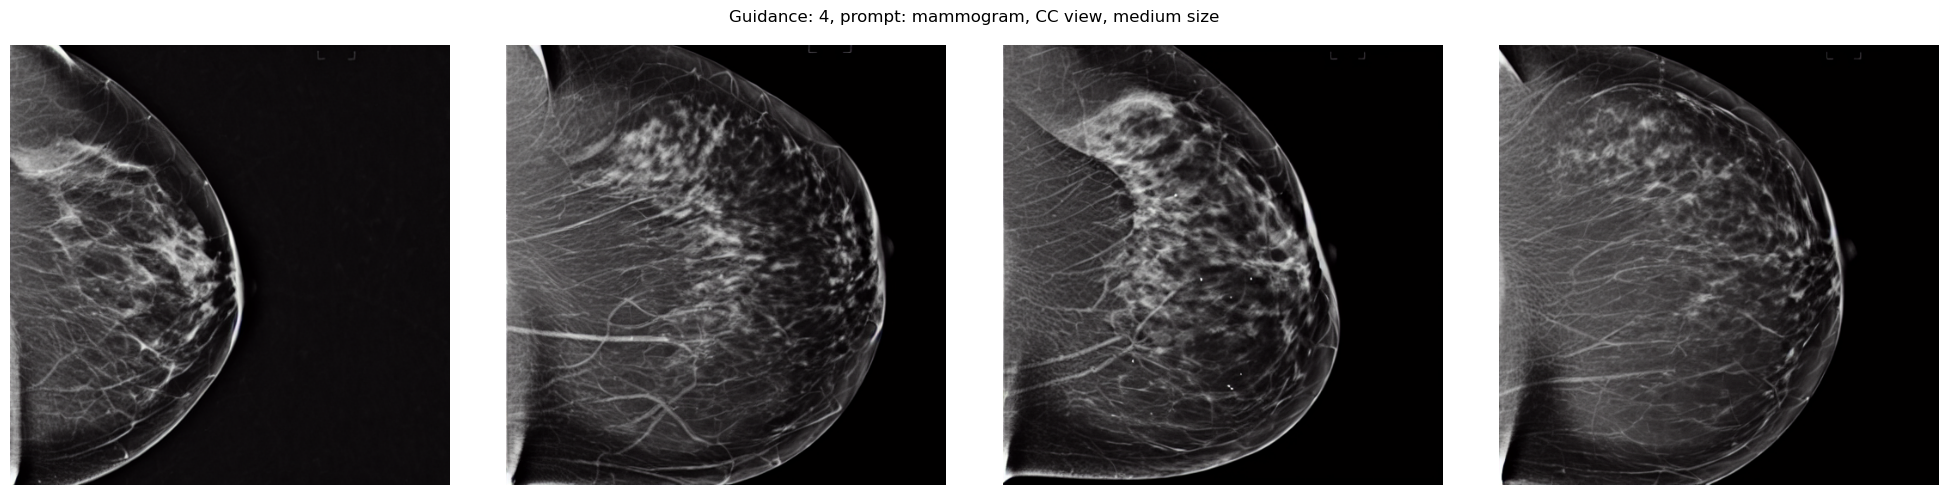

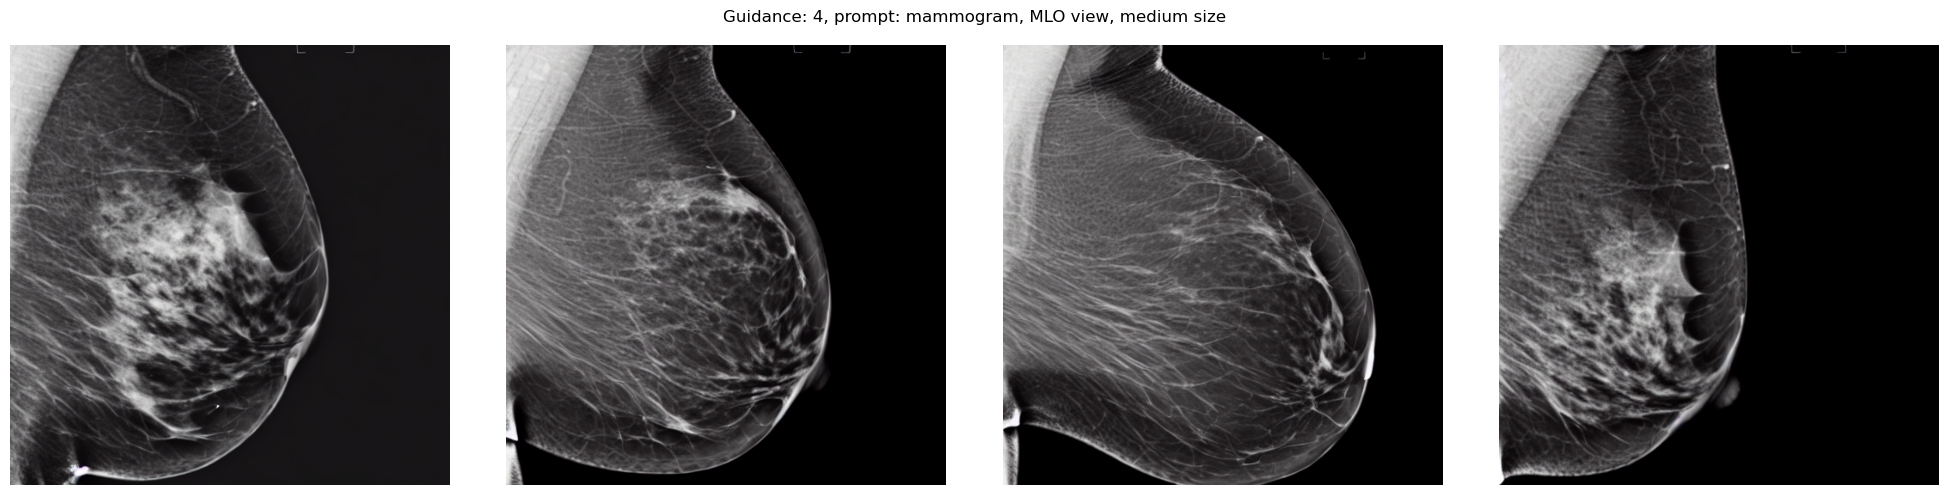

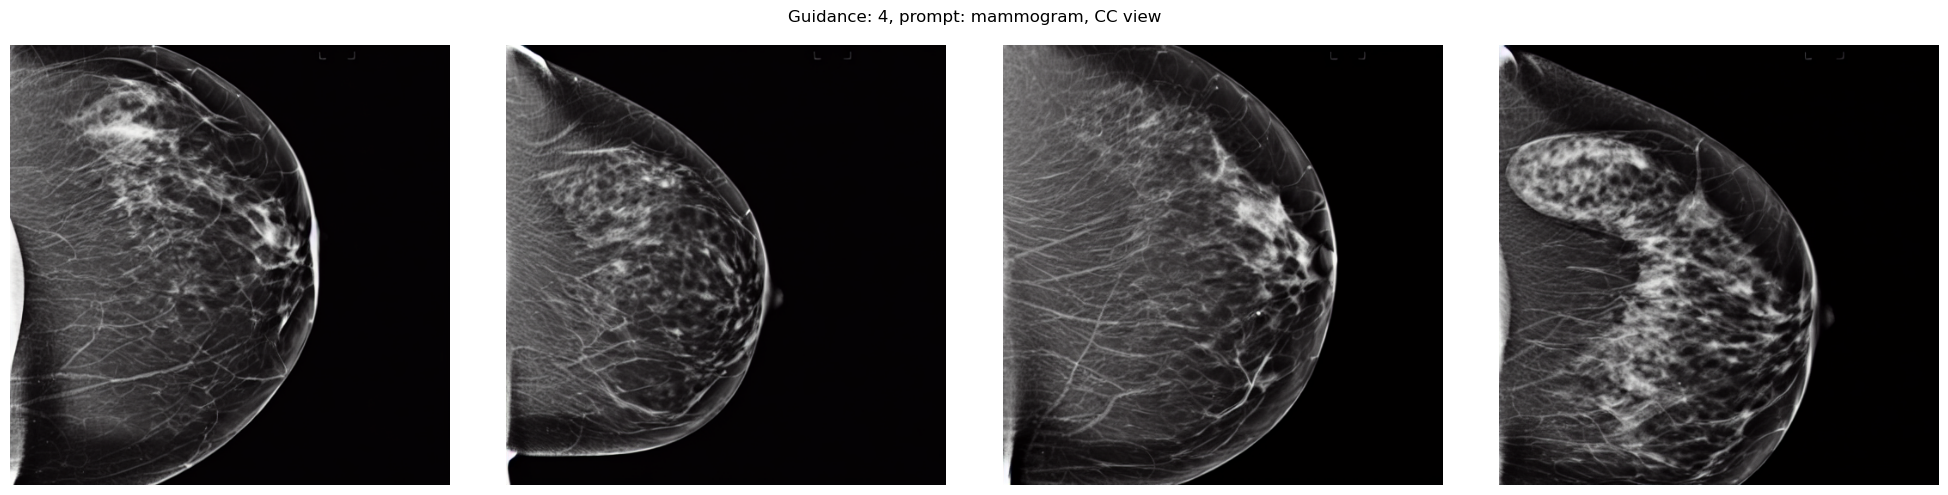

In [6]:
# Saving images
saving_images = True
saving_name = output_dir.replace('Likalto4/', '')
saving_folder = repo_path / 'experiments/inference/data/synthetic' / saving_name
saving_folder.mkdir(parents=False, exist_ok=True)

# Param
for guidance_scale in range(4,5):    
    for prompt in ['mammogram, CC view, medium size','mammogram, MLO view, medium size', 'mammogram, CC view' ]:
        # Seed
        seed = 2
        generator.manual_seed(seed)
        negative_prompt = ""
        num_samples = 4
        num_inference_steps = 50
        size = 512
        with torch.autocast("cuda"), torch.inference_mode():
            image = pipe(
                prompt=prompt,
                negative_prompt=negative_prompt,
                num_images_per_prompt=num_samples,
                num_inference_steps=num_inference_steps,
                guidance_scale=guidance_scale,
                height=size,
                width=size,
                # generator=generator,
            ).images
        # images in list
        imgs = [np.asarray(img) for img in image]

        show_row(imgs, title=f'Guidance: {guidance_scale}, prompt: {prompt}', figsize=(20,5), cmap="gray") if len(imgs) > 1 else plt.imshow(imgs[0], cmap="gray")

        # save images
        if saving_images:
            prompt_save = prompt.replace(', ', '_').replace(' ', '_')
            for i, img in enumerate(imgs):
                cv.imwrite(str(saving_folder / f'{prompt_save}_{guidance_scale}_{i}.png'), img)
        
        # free memory
        del image
        del imgs
        torch.cuda.empty_cache()
        